# Shallow water equation solver with Lax-Wendroff 

Shallow water equations (SWEs) are partial differential equations in time t and space (x,y). They describe the movement of a liquid surface under gravity and under the assumption that the depth is neglible compared to the lateral dimensions. 
The solution returns the velocity profile in x and y, given by the variables u and v as well as the height of the fluid body h at any time of interest. 

They are hyperbolic equations, that means that for any set of inital conditions we can be sure that a solution for the velocity u(x,y) and v(x,y) and the height profile h(x,y) exists. 

SWEs are derived from the Navier-Stokes equations by integrating over the depth, under the condition that the velocity in the z-direction is neglible.  

Note that in its essense the Navier-Stokes equations 
follow from the conservation of mass and momentum for Newtonian fluids.

Hence, the shallow water equations with neglible Coriolis force and neglible viscosity are given by 

1. $\frac{\partial h}{\partial t} + \frac{\partial (uh)}{\partial x} + \frac{\partial (vh)}{\partial y} = 0$,

2. $\frac{\partial (uh)}{\partial t} + \frac{\partial (u^2 h + \frac{1}{2}g h^2)}{\partial x} + \frac{\partial (uvh)}{\partial y} = 0$,

3. $\frac{\partial (vh)}{\partial t} + \frac{\partial (uvh)}{\partial x} + \frac{\partial (v^2 h + \frac{1}{2}g h^2)}{\partial y} = 0$, 

where g is the gravitational constant. 

*TBC* for numerical equations and solving method drawbacks. 


## 1. Set simulation parameteres 

In [49]:
import numpy as np 

# Domain geometry - square grid 
domain_size = 10


x_1 = 0
x_2 = 10
n_grid = 1000

# define grid points in 1d 
lgrid  = np.linspace(x_1,x_2,n_grid)

# mesh for square domain with extent (x_1-x_2)
x,y = np.meshgrid(lgrid, lgrid)

# grid spacing 
delta_x = (x_2-x_1)/n_grid  
delta_y = delta_x 

# Boundary conditions reflective boundaries, velocities are zero  
u_boundary = 0 
v_boundary = 0 

# total simulation time Tmax and time increment delta_t 
Tmax = 1
# that sets the units to meter and seconds 
g=9.81
H=1
delta_t = (0.1*delta_x)/np.sqrt(g*H)
print("delta_t", delta_t)
n_times = np.int32(Tmax/delta_t)

# Arrays holding the solutions for each time step starting with 
# inital condition where height is 1 everywhere and u,v are zero 
h = np.zeros((n_times, n_grid, n_grid))
u = np.zeros((n_times, n_grid, n_grid))
v = np.zeros((n_times, n_grid, n_grid))

# 2D gaussian disturbance at location mu
# and with variance var with shapes var.shape and mu.shape = (2,)
def gauss2d(mu,var,x,y):
    return 1. / (2. * np.pi * var[0] * var[1]) * np.exp(-((x - mu[0])**2. / (2. * var[0]**2.) + (y - mu[1])**2. / (2. * var[1]**2.)))

extent = x_2-x_1
mu = np.array([0.1*extent, 0.1*extent])
var = 0.02*extent*np.ones(2)

#sigma = np.zeros((n_grid,n_grid))
#sigma = 0.0001*np.exp(-((x-x_2/2)**2/(2*(1E+5)**2) + (x-x_2/2)**2/(2*(1E+5)**2)))
#eta_n = np.exp(-((x-x_2/2.7)**2/(2*(0.05E+6)**2) + (y-x_2/4)**2/(2*(0.05E+6)**2)))

h[0,:] = h[0,:] + H*np.ones((n_grid,n_grid)) + 0.05*gauss2d(mu,var,x,y)

# maintaining boundary conditions 
def set_const_boundaries(field,value):
    
    field[-1,:] = value
    field[0,:] = value
    field[:,-1] = value
    field[:,0] = value  
    
    return field

h[0,:,:] = set_const_boundaries(h[0,:,:],1)
u[0,:,:] = set_const_boundaries(u[0,:,:],0)
v[0,:,:] = set_const_boundaries(v[0,:,:],0)



delta_t 0.00031927542840705044


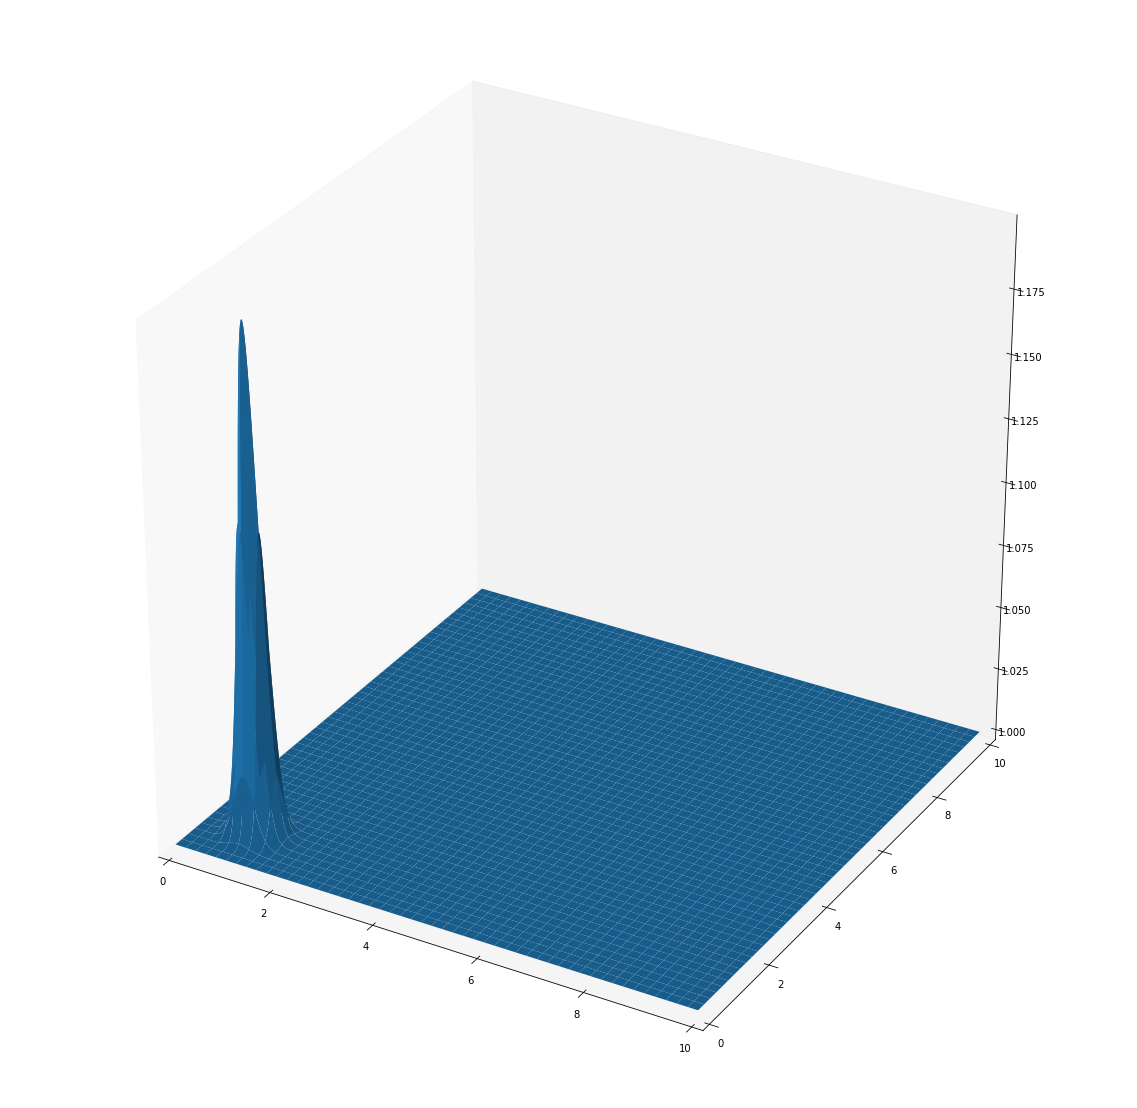

In [50]:
from scipy.stats import norm 
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns 

fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
z=h[0,:]
ax.set_xlim([x_1,x_2])
ax.set_ylim([x_1,x_2])
ax.plot_surface(x,y,z)
ax.grid('False')
plt.show()



In [51]:

hn = h[0,:]
un = u[0,:]
vn = v[0,:]



# define Un,Fn,Gn 

def get_transformed_vars(hn,un,vn):
    Un = np.array([hn, un*hn, vn*hn])
    Fn = np.array([un*hn, np.power(un,2)*hn + 0.5*g*np.power(hn,2), un*vn*hn])
    Gn = np.array([vn*hn, un*hn*vn, np.power(vn,2)*hn + 0.5*g*np.power(hn,2)])

    return Un,Fn,Gn 

def get_FG(Un):
    hn = Un[0]
    un = Un[1]/hn
    vn = Un[2]/hn
    
    Fn = np.array([un*hn, np.power(un,2)*hn + 0.5*g*np.power(hn,2), un*vn*hn])
    Gn = np.array([vn*hn, un*hn*vn, np.power(vn,2)*hn + 0.5*g*np.power(hn,2)])

    return Fn,Gn
    
Un,Fn,Gn = get_transformed_vars(hn,un,vn)

Un_xmid = np.array([np.ones((n_grid+1, n_grid)),
                    np.zeros((n_grid+1, n_grid)),
                    np.zeros((n_grid+1, n_grid))])
                        
Un_ymid = np.array([np.ones((n_grid, n_grid+1)),
                    np.zeros((n_grid, n_grid+1)),
                    np.zeros((n_grid, n_grid+1))])
                                      
 


In [52]:

t_range = np.int64(Tmax/delta_t)
print(t_range)
for t in range(t_range):
    
    
    Un_xmid = np.array([np.ones((n_grid+1, n_grid)),
                    np.zeros((n_grid+1, n_grid)),
                    np.zeros((n_grid+1, n_grid))])
                        
    Un_ymid = np.array([np.ones((n_grid, n_grid+1)),
                    np.zeros((n_grid, n_grid+1)),
                    np.zeros((n_grid, n_grid+1))])
                                      

    Un_xmid[:,1:-1,:] = 0.5*(Un[:,1:,:] + Un[:,:-1,:]) 
    - (delta_t/(2*delta_x))*(Fn[:,1:,:] - Fn[:,:-1,:])
    
    Un_ymid[:,:,1:-1] = 0.5*(Un[:,:,1:] + Un[:,:,:-1]) 
    - (delta_t/(2*delta_y))*(Gn[:,:,1:] - Gn[:,:,:-1])
    
    
    Fn_xmid,Gn_xmid = get_FG(Un_xmid)
    Fn_ymid,Gn_ymid = get_FG(Un_ymid)
    
    
    Xterm = (delta_t/delta_x)*(Fn_xmid[:,1:,:] - Fn_xmid[:,:-1,:]) 
    Yterm = (delta_t/delta_y)*(Gn_ymid[:,:,1:] - Gn_ymid[:,:,:-1])
   
    print(t, np.max(Xterm))

    Un = Un - Xterm - Yterm 
    
    hn =  Un[0]
    un =  Un[1]/Un[0]
    vn =  Un[2]/Un[0]
    
    hn = set_const_boundaries(hn,1)
    un = set_const_boundaries(un,0)
    vn = set_const_boundaries(vn,0)
    
    Un, Fn,Gn = get_transformed_vars(hn,un,vn)

    

3132
0 0.0021238897861947156
1 0.00212388902358245
2 0.002123685370742145
3 0.0021232788283707957
4 0.00212266942388313
5 0.0021218572114203704
6 0.0021208422718649233
7 0.0021196247128597184
8 0.002118204668834298
9 0.002116582301035272
10 0.0021147577975625317
11 0.002112731373411415
12 0.0021105032705189884
13 0.0021080737578155974
14 0.0021054431312819816
15 0.002102611714010183
16 0.0020995798562694515
17 0.002096347935576484
18 0.0020929163567692958
19 0.0020892855520854314
20 0.002085455981243489
21 0.002081428131527772
22 0.0020772025178765305
23 0.00207277968297206
24 0.0020681601973335647
25 0.002063344659412727
26 0.0020583336956893554
27 0.0020531279607702933
28 0.002047728137487905
29 0.002042323757211423
30 0.0020368943715144724
31 0.0020312835407151064
32 0.002025491878953656
33 0.0020195200237158994
34 0.002013368636019769
35 0.0020070384005993302
36 0.0020005300260924246
37 0.0019938442452260684
38 0.0019869818150035565
39 0.001979943516889521
40 0.0019727301569944238


322 0.0009593523842737143
323 0.0009603900261980903
324 0.0009613563875711286
325 0.0009622521376109414
326 0.0009630779441784868
327 0.0009638344736649608
328 0.0009645223908814595
329 0.0009651423589531776
330 0.0009656950392166126
331 0.0009661810911194643
332 0.0009666011721258915
333 0.000966955937622367
334 0.0009673441811576413
335 0.0009678710556869566
336 0.0009683317935575555
337 0.0009687270513481387
338 0.0009690574837026698
339 0.0009693237432345273
340 0.0009695264804328971
341 0.0009696663435735597
342 0.0009697439786319476
343 0.0009697600291995468
344 0.0009697151364039013
345 0.0009696099388303181
346 0.0009694450724476565
347 0.0009692211705362713
348 0.0009689931753458501
349 0.0009689487301344366
350 0.0009688445015442206
351 0.0009686811227928306
352 0.0009684592245137459
353 0.0009681794346823413
354 0.0009678423785434617
355 0.0009674486785433077
356 0.0009669989542626831
357 0.0009664938223540693
358 0.0009659338964803735
359 0.0009653197872574771
360 0.0009646

641 0.0043661046604504
642 0.004404535878884669
643 0.0044431874950195205
644 0.004482058799086363
645 0.004521149031672322
646 0.004560457382750273
647 0.004599982990700771
648 0.0046397249413288435
649 0.004679682266874147
650 0.004719853945015825
651 0.0047602388978724266
652 0.004800835990997321
653 0.004841644032369402
654 0.004882661771380985
655 0.004923887897822046
656 0.004965321040861968
657 0.005006959768029553
658 0.005048802584191563
659 0.0050908479305301815
660 0.005133094183520391
661 0.005175539653908684
662 0.005218182585691827
663 0.005261021155098435
664 0.005304053469573384
665 0.005347277566765309
666 0.005390691413518727
667 0.005434292904872059
668 0.005478079863060755
669 0.005522050036528987
670 0.005566201098948617
671 0.005610530648247688
672 0.005655036205649321
673 0.005699715214722437
674 0.005744565040444342
675 0.005789582968277553
676 0.005834766203262194
677 0.00588011186912396
678 0.005925617007400423
679 0.00597127857658575
680 0.006017093451296908


971 0.010600129647000718
972 0.010596412964439316
973 0.010592120877475695
974 0.010587256936380997
975 0.010581824785736035
976 0.010575828160655202
977 0.010572235667349883
978 0.010570515799095006
979 0.01056821323681834
980 0.010565331280203379
981 0.010561873334735138
982 0.010557842907809346
983 0.01055324360485518
984 0.010548079125475627
985 0.010542353259611269
986 0.0105397782860499
987 0.010538506271591506
988 0.010536654218243294
989 0.01053422546382515
990 0.010531223453049889
991 0.010527651733559875
992 0.010523513951976374
993 0.010518813849969657
994 0.010513555260353198
995 0.010511719673564967
996 0.010511109328278733
997 0.010509921722362231
998 0.010508160216097575
999 0.010505828278820357
1000 0.010502929484875557
1001 0.0104994675095858
1002 0.010495446125240183
1003 0.010490869197107934
1004 0.010489797489121976
1005 0.01049008518369629
1006 0.010489798794862058
1007 0.010488941690127158
1008 0.010487517349317592
1009 0.01048552936044423
1010 0.01048298141558115

1292 0.01723607555008091
1293 0.017176502832065996
1294 0.01711646113889768
1295 0.01705595874912218
1296 0.016995003859260747
1297 0.0169336045840321
1298 0.016871768956571716
1299 0.016809504928647627
1300 0.016746820370876166
1301 0.016683723072937383
1302 0.016620220743792543
1303 0.016556321011906117
1304 0.01649203142547222
1305 0.016427359452648647
1306 0.016362312481799184
1307 0.016296897821746776
1308 0.01623112270203815
1309 0.016164994273221437
1310 0.016098519607139036
1311 0.01603170569723562
1312 0.01596455945888389
1313 0.015897087729727706
1314 0.015829297270043678
1315 0.015761194763123546
1316 0.015692786815675434
1317 0.015624079958245865
1318 0.015555080645662755
1319 0.015485795257499296
1320 0.015416230098558562
1321 0.015346391399378266
1322 0.015276285316757017
1323 0.015205917934299238
1324 0.015135295262980379
1325 0.015064423241730572
1326 0.014993307738035297
1327 0.014921954548554819
1328 0.014850369399757972
1329 0.014778557948571634
1330 0.01470652578304

1610 0.008745232899038903
1611 0.008743975720384857
1612 0.008742118432816888
1613 0.008739670322523676
1614 0.008736640777476976
1615 0.008733039269070157
1616 0.008731854279145105
1617 0.008731780664250455
1618 0.008731087124253816
1619 0.008729782815289864
1620 0.008727877034999167
1621 0.008725379203351412
1622 0.008722298843665119
1623 0.008718645563879253
1624 0.008717913483779713
1625 0.008717805602803464
1626 0.008717075970327014
1627 0.008715733870991895
1628 0.008713788733675261
1629 0.008711250111942525
1630 0.008708127664692433
1631 0.008704431137050845
1632 0.008704089605308328
1633 0.008703957169618016
1634 0.008703200948224925
1635 0.008701830353113683
1636 0.008699854943687286
1637 0.008697284406841697
1638 0.008694128537227225
1639 0.008690397217754204
1640 0.008690383722718643
1641 0.008690236423686696
1642 0.008689463092046178
1643 0.008688073265801658
1644 0.008686076634026745
1645 0.00868348301655356
1646 0.008680302343842022
1647 0.008676544637087188
1648 0.008676

1928 0.008286071566171874
1929 0.008285846431809593
1930 0.008284858940800877
1931 0.008283123105396098
1932 0.008280653360995626
1933 0.008277464531195574
1934 0.008273860178954554
1935 0.00827557056830023
1936 0.008276480612453584
1937 0.008276603234285789
1938 0.008275951874902704
1939 0.00827454046027977
1940 0.008272383366995926
1941 0.008269495387183353
1942 0.00826589169281478
1943 0.00826554557397369
1944 0.00826683162257229
1945 0.008267318533650578
1946 0.008267019608536676
1947 0.008265948661536718
1948 0.008264119985751746
1949 0.008261548318018544
1950 0.008258248803093903
1951 0.008255428215724196
1952 0.008257107336931054
1953 0.008257975415199294
1954 0.008258045586287567
1955 0.008257331527755391
1956 0.008255847424930036
1957 0.008253607935898239
1958 0.008250628155645237
1959 0.008246923579463657
1960 0.008247289102303552
1961 0.008248555755099416
1962 0.008249012241522476
1963 0.008248672074320687
1964 0.008247549303574978
1965 0.008245658481838456
1966 0.0082430146

2246 0.008008636868498658
2247 0.008009677804975354
2248 0.008009681739942367
2249 0.008008664776215473
2250 0.008006644073160806
2251 0.008003637803661538
2252 0.007999665108431902
2253 0.007998573003946085
2254 0.008001541589828735
2255 0.008003438651430215
2256 0.008004278289045881
2257 0.008004075749271273
2258 0.008002847387134226
2259 0.008000610625236985
2260 0.007997383910053571
2261 0.007993186665541567
2262 0.007993801376557861
2263 0.007996585798219172
2264 0.00799829291084939
2265 0.007998937036546512
2266 0.007998533656484971
2267 0.007997099372485671
2268 0.00799465186555416
2269 0.00799120985153346
2270 0.007986793034033789
2271 0.007989072497826035
2272 0.007991678762708215
2273 0.007993201809984668
2274 0.007993656179073634
2275 0.007993057581448531
2276 0.00799142286163791
2277 0.007988769955148106
2278 0.007985117843465166
2279 0.007980853523997593
2280 0.007984390586861914
2281 0.007986824851571678
2282 0.007988169846001852
2283 0.007988440319844772
2284 0.007987652

2564 0.007862378999914288
2565 0.00786126291928557
2566 0.007865960474369117
2567 0.007869251672342247
2568 0.007871147890025224
2569 0.007871662446085101
2570 0.007870810573061068
2571 0.00786860938351446
2572 0.007865077830415419
2573 0.007860236661905351
2574 0.007858739414148164
2575 0.007863538401861006
2576 0.00786692019205599
2577 0.00786889596464482
2578 0.00786947886745044
2579 0.007868683988933376
2580 0.007866528324942211
2581 0.00786303073959811
2582 0.007858211920447836
2583 0.007856259452051081
2584 0.007861169238984046
2585 0.007864650905252266
2586 0.007866715417639607
2587 0.007867375736925128
2588 0.00786664679136144
2589 0.007864545444081533
2590 0.007861090454535298
2591 0.007856302434093384
2592 0.007853822778947708
2593 0.007858852848914228
2594 0.00786244376913163
2595 0.007864606276634786
2596 0.007865353128960688
2597 0.00786469907843593
2598 0.007862660840289621
2599 0.00785925705469072
2600 0.007854508242842055
2601 0.00785142514480834
2602 0.0078565851220988

2882 0.007836203505638871
2883 0.007830758943762658
2884 0.007823932356404145
2885 0.007831262784882179
2886 0.007836788166872704
2887 0.007840512660494552
2888 0.007842443331133585
2889 0.007842590151691267
2890 0.007840965993112342
2891 0.007837586605158584
2892 0.00783247058745607
2893 0.007825639350891584
2894 0.007830276884655634
2895 0.007836237389247899
2896 0.007840383479079276
2897 0.0078427213940929
2898 0.007843260313331227
2899 0.00784201234840879
2900 0.007838992527105997
2901 0.007834218767091044
2902 0.007827711839831815
2903 0.007829226500515828
2904 0.00783563539761012
2905 0.007840216496875756
2906 0.00784297518539335
2907 0.007843919820408177
2908 0.007843061725849098
2909 0.007840415178842378
2910 0.007835997386210389
2911 0.007829828451002295
2912 0.007828102668821354
2913 0.007834973374029245
2914 0.007840003077777092
2915 0.007843196285610414
2916 0.007844560503433783
2917 0.007844106237192913
2918 0.007841846982431929
2919 0.007837799203696925
2920 0.00783198230

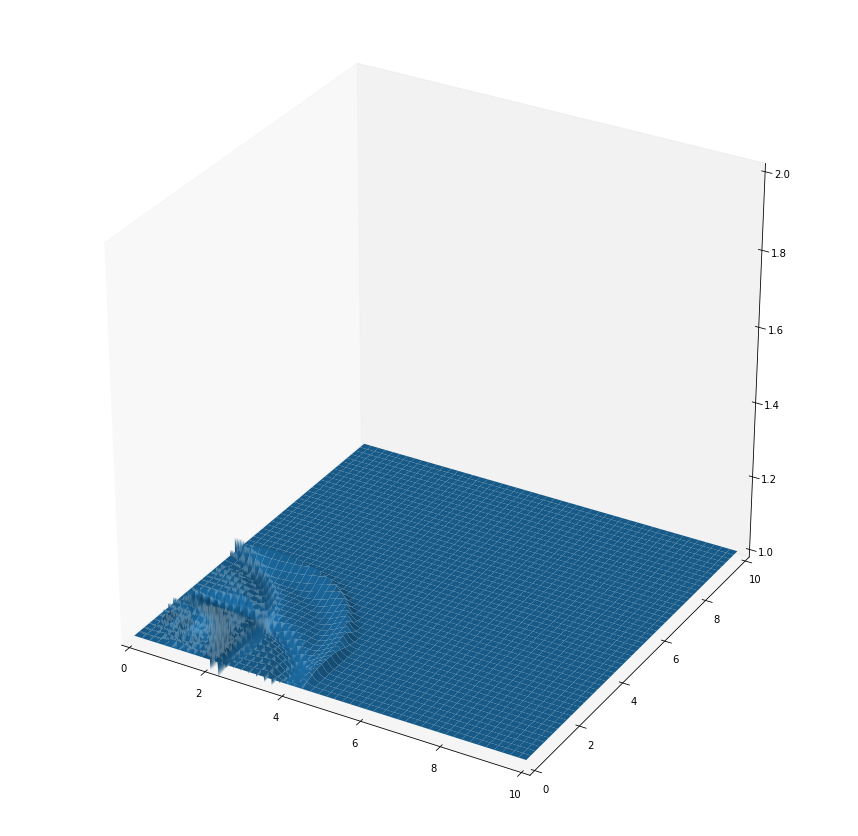

In [53]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
z=Un[0]
ax.set_xlim([x_1,x_2])
ax.set_ylim([x_1,x_2])
ax.set_zlim([1,2])
ax.plot_surface(x,y,z)
ax.grid('False')
plt.show()